In [1]:
!pip install coppeliasim-zmqremoteapi-client


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Imports

In [1]:
import sys
import coppeliasim_zmqremoteapi_client
import time
import math
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv
import numpy as np
import heapq

In [2]:
sys.path.append(r"D:\CoppeliaRobotics\CoppeliaSimEdu\programming\zmqRemoteApi\clients\python")

# Initial Setup

In [ ]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

client = RemoteAPIClient()
sim = client.getObject('sim')

sim.startSimulation()
print("Simulation started...")
time.sleep(3)
sim.stopSimulation()
print("Simulation stopped successfully!")

Simulation started...
Simulation stopped successfully!


# Initializing Objects

In [ ]:
base_handle = sim.getObject('/RobotnikSummitXL')
wheel_names = ['/front_left_wheel', '/front_right_wheel','/back_left_wheel','/back_right_wheel']
wheel_handles = [sim.getObject(n) for n in wheel_names]
print(wheel_handles)

[64, 76, 58, 70]


# Handler Functions

## Object Handlers

In [ ]:
def set_wheel_velocities(v_fl, v_fr, v_rl, v_rr):
    sim.setJointTargetVelocity(wheel_handles[0], v_fl)
    sim.setJointTargetVelocity(wheel_handles[1], -v_fr)
    sim.setJointTargetVelocity(wheel_handles[2], v_rl)
    sim.setJointTargetVelocity(wheel_handles[3], -v_rr)

def set_all_wheels(v):
    set_wheel_velocities(v, v, v, v)

def set_wheel_speeds(lin_speed, ang_speed):
    v_left = lin_speed - ang_speed
    v_right = lin_speed + ang_speed
    
    sim.setJointTargetVelocity(wheel_handles[0], v_left)   # front-left
    sim.setJointTargetVelocity(wheel_handles[1], -v_right)  # front-right
    sim.setJointTargetVelocity(wheel_handles[2], v_left)   # rear-left
    sim.setJointTargetVelocity(wheel_handles[3], -v_right)  # rear-right


def stop_wheels():
    set_all_wheels(0.0)

def get_base_position():
    return sim.getObjectPosition(base_handle, -1)

def get_base_yaw():
    ori = sim.getObjectOrientation(base_handle, -1)
    return ori[2]

def angle_diff(a, b):
    d = (a - b + math.pi) % (2*math.pi) - math.pi
    return d


## Motion Handlers

In [33]:
def rotate_in_place(direction=1, rot_speed=2.0, duration=None, until_angle=None):
    left_vel = -direction * rot_speed
    right_vel = direction * rot_speed

    if until_angle is None:
        set_wheel_velocities(left_vel, right_vel, left_vel, right_vel)
        time.sleep(duration)
        stop_wheels()
    else:
        while True:
            yaw = get_base_yaw()
            d = angle_diff(until_angle, yaw)
            if abs(d) < 0.05:
                break
            set_wheel_velocities(left_vel, right_vel, left_vel, right_vel)
            time.sleep(0.01)
        stop_wheels()


# Initializing Sensors

In [9]:
from scipy.ndimage import binary_dilation
try:
    from scipy.ndimage import binary_dilation
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False
    print("Warning: scipy not found; obstacle inflation will use a simple fallback.")


In [ ]:
sensor_names = {
    # "s": "/proximity_detect",
    "f": "/proximity_f",
    "fl": "/proximity_fl",
    "fr": "/proximity_fr",
}

sensor_handles = {}
for k, name in sensor_names.items():
    try:
        sensor_handles[k] = sim.getObject(name)
    except Exception:
        sensor_handles[k] = None
        print(f"Warning: sensor {name} not found")


In [32]:
def read_proximity_world(sim, sensor_handle):
    if sensor_handle is None:
        return False, None, None
    try:
        res = sim.readProximitySensor(sensor_handle)
    except Exception:
        return False, None, None

    if not res:
        return False, None, None

    try:
        detected = bool(res[0])
    except Exception:
        return False, None, None

    if not detected:
        return False, None, None


    distance = None
    detectedPoint = None
    if len(res) >= 2:
        distance = res[1]
    if len(res) >= 3:
        detectedPoint = res[2]

    if detectedPoint is not None:
        try:
            sensor_pos, R = get_world_pose(sim, sensor_handle)
            local_pt = np.array(detectedPoint)
            world_pt = sensor_pos + R.dot(local_pt)
            return True, (float(world_pt[0]), float(world_pt[1]), float(world_pt[2])), float(distance) if distance is not None else None
        except Exception:
            # fallback: if conversion fails, return distance-only
            return True, None, float(distance) if distance is not None else None

    if distance is not None:
        try:
            s_pos, R = get_world_pose(sim, sensor_handle)
            dir_world = R[:,0]
            world_pt = s_pos + dir_world * distance
            return True, (float(world_pt[0]), float(world_pt[1]), float(world_pt[2])), float(distance)
        except Exception:
            return True, None, float(distance)

    return False, None, None

# Testing Sensors (Need not run)

In [ ]:
def get_world_pose(sim, obj_handle):
    pos = sim.getObjectPosition(obj_handle, -1)
    eul = sim.getObjectOrientation(obj_handle, -1)
    cz = math.cos(eul[2]); sz = math.sin(eul[2])
    cy = math.cos(eul[1]); sy = math.sin(eul[1])
    cx = math.cos(eul[0]); sx = math.sin(eul[0])
    Rz = np.array([[cz, -sz, 0],[sz, cz, 0],[0,0,1]])
    Ry = np.array([[cy,0,sy],[0,1,0],[-sy,0,cy]])
    Rx = np.array([[1,0,0],[0,cx,-sx],[0,sx,cx]])
    R = Rz.dot(Ry).dot(Rx)
    return np.array(pos), R

def sweep_ray_and_collect(sim, sweep_handle, sweep_dummy_handle, angles_deg, delay=0.01):
    pts = []
    for ang in angles_deg:
        sim.setObjectOrientation(sweep_dummy_handle, -1, [0.0, 0.0, math.radians(ang)])
        time.sleep(delay)
        detected, pt, dist = read_proximity_world(sim, sweep_handle)
        if detected:
            pts.append(pt)
    return pts


def read_all_sensors_world(sim, sensor_handles):

    pts = []
    for name, h in sensor_handles.items():
        ok, world_pt, dist = read_proximity_world(sim, h)
        print(ok, world_pt, dist)
        if ok and (world_pt is not None):
            pts.append(world_pt)
    return pts

In [ ]:
def build_occupancy_grid(points, origin_xy=(-10.0, -10.0), grid_size_m=(20.0, 20.0),
                         resolution=0.1, inflate_radius=0.25):
    xmin, ymin = origin_xy
    w_m, h_m = grid_size_m
    cols = int(round(w_m / resolution))
    rows = int(round(h_m / resolution))
    grid = np.zeros((rows, cols), dtype=np.uint8)

    def world_to_cell(x, y):
        cx = int(math.floor((x - xmin) / resolution))
        cy = int(math.floor((y - ymin) / resolution))
        return cx, cy

    for (x, y, z) in points:
        cx, cy = world_to_cell(x, y)
        if 0 <= cx < cols and 0 <= cy < rows:
            grid[cy, cx] = 1

    inflate_cells = int(math.ceil(inflate_radius / resolution))
    if inflate_cells > 0:
        if _HAS_SCIPY:
            grid = binary_dilation(grid.astype(bool),
                                   structure=np.ones((2*inflate_cells+1, 2*inflate_cells+1))).astype(np.uint8)
        else:
            new_grid = grid.copy()
            rows_range = range(rows)
            cols_range = range(cols)
            for cy in rows_range:
                for cx in cols_range:
                    if grid[cy, cx] == 1:
                        r0 = max(0, cy-inflate_cells); r1 = min(rows-1, cy+inflate_cells)
                        c0 = max(0, cx-inflate_cells); c1 = min(cols-1, cx+inflate_cells)
                        new_grid[r0:r1+1, c0:c1+1] = 1
            grid = new_grid

    info = {
        'origin': (xmin, ymin),
        'rows': rows,
        'cols': cols,
        'resolution': resolution,
        'width_m': w_m,
        'height_m': h_m
    }
    return grid, info

False None None
False None None
False None None
[]
Detected 0 obstacle points (world). Sample: []
Grid built: {'origin': (-10.0, -10.0), 'rows': 200, 'cols': 200, 'resolution': 0.1, 'width_m': 20.0, 'height_m': 20.0}


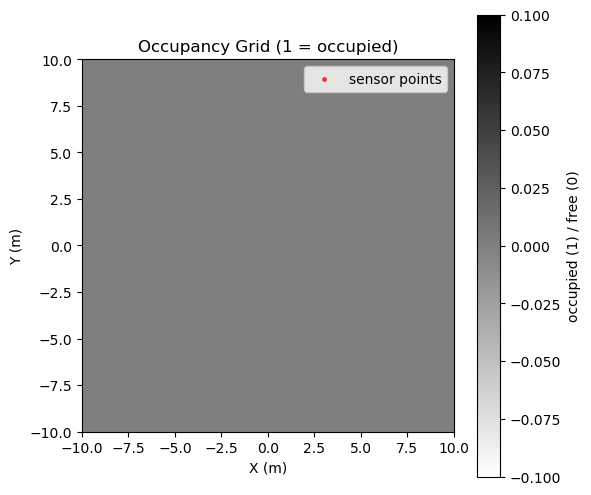

In [ ]:
# -------------------------
# Short main test
# -------------------------
stop_wheels()
time.sleep(0.1)

pts = read_all_sensors_world(sim, sensor_handles)
print(pts)
print(f"Detected {len(pts)} obstacle points (world). Sample: {pts[:6]}")

origin_xy = (-10.0, -10.0)
grid_size_m = (20.0, 20.0)
resolution = 0.1
inflate_radius = 0.3 

grid, info = build_occupancy_grid(pts,
                                  origin_xy=origin_xy,
                                  grid_size_m=grid_size_m,
                                  resolution=resolution,
                                  inflate_radius=inflate_radius)

print("Grid built:", info)

xmin, ymin = info['origin']
xmax = xmin + info['width_m']
ymax = ymin + info['height_m']
extent = [xmin, xmax, ymin, ymax]

plt.figure(figsize=(6,6))
plt.imshow(grid, origin='lower', cmap='gray_r', extent=extent, interpolation='nearest')
plt.title("Occupancy Grid (1 = occupied)")
plt.xlabel("X (m)"); plt.ylabel("Y (m)")
plt.colorbar(label='occupied (1) / free (0)')
plt.scatter([p[0] for p in pts], [p[1] for p in pts], s=6, c='red', alpha=0.7, label='sensor points')
plt.legend(loc='upper right')
plt.show()

# Obstacle Avoidance Helpers

In [ ]:
def read_all_sensors_world_raw(sensor_handles=sensor_handles):
    pts = []
    raw = {}
    for name, h in sensor_handles.items():
        ok, world_pt, dist = read_proximity_world(sim, h)
        raw[name] = (ok, world_pt, dist)
        if ok and (world_pt is not None):
            pts.append(world_pt)
    return pts, raw

In [ ]:
def log_current_position(log, sim_start_time):
    pos = get_base_position()
    elapsed = time.time() - sim_start_time
    log.append([round(pos[0],3), round(pos[1],3), round(pos[2],3), round(elapsed,2)])

_OBS_STATE = {
    "prev_ang": 0.0,
    "prev_time": time.time(),
    "prev_ang_cmd": 0.0,
}

def obstacle_avoidance_diff(sensor_data,
                            max_forward=0.8,
                            min_forward=0.10,
                            front_slow_ratio=0.55,
                            ang_gain=2.2,
                            ang_cap=2.4,
                            dist_max=1.6,
                            smoothing_tau=0.10,
                            accel_limit=4.0):
    """
    Differential drive obstacle avoidance with front sensitivity and adaptive stuck/side handling.
    """
    sensor_angles = {
        'fl': math.radians(45.0),
        'f': 0.0,
        'fr': math.radians(-45.0)
    }

    weights = {}
    for k in sensor_angles:
        entry = sensor_data.get(k)
        if (not entry) or (entry[2] is None):
            weights[k] = 0.0
            continue
        d = float(entry[2])
        d = max(0.0, min(d, dist_max))
        w = (dist_max - d) / dist_max
        if k == 'f':
            w *= 1.6 
        weights[k] = w

    total_w = sum(weights.values())

    steer = 0.0
    if total_w > 0.0:
        for k, w in weights.items():
            steer += -sensor_angles[k] * w
        steer /= total_w

    triggered = [k for k, w in weights.items() if w > 0.3]
    num_triggered = len(triggered)

    front_w = weights['f'] + 0.6 * (weights['fl'] + weights['fr'])
    side_triggered = (weights['fl'] > 0.3) ^ (weights['fr'] > 0.3)

    if num_triggered >= 2:
        linear_vel = -0.2 
        if 'fl' not in triggered:
            steer = sensor_angles['fl']
        elif 'fr' not in triggered:
            steer = sensor_angles['fr']
        else:
            steer = math.pi * 0.5
    elif side_triggered and weights['f'] < 0.2:
        linear_vel = max(min_forward, max_forward * (1.0 - 0.2 * front_w))
    else:
        linear_vel = max(min_forward, max_forward * (1.0 - front_slow_ratio * front_w))

    if weights['fl'] > 0.9 and weights['fr'] > 0.9 and weights['f'] < 0.3:
        linear_vel = min(linear_vel, 0.25)
        steer *= 0.3
    if (weights['f'] > 0.6) and (weights['fl'] > 0.6 or weights['fr'] > 0.6):
        steer *= 1.4
        linear_vel = min(linear_vel, 0.35)

    raw_ang = ang_gain * steer
    raw_ang = max(-ang_cap, min(ang_cap, raw_ang))

    now = time.time()
    dt = max(1e-4, now - _OBS_STATE["prev_time"])
    max_dang = accel_limit * dt
    prev_cmd = _OBS_STATE["prev_ang_cmd"]
    dang = raw_ang - prev_cmd
    if abs(dang) > max_dang:
        raw_ang = prev_cmd + math.copysign(max_dang, dang)

    alpha = dt / (smoothing_tau + dt)
    ang_smoothed = (1.0 - alpha) * _OBS_STATE["prev_ang"] + alpha * raw_ang

    #Update state
    _OBS_STATE.update({
        "prev_ang": ang_smoothed,
        "prev_time": now,
        "prev_ang_cmd": raw_ang
    })
    linear_vel = max(linear_vel, min_forward)

    return linear_vel, ang_smoothed


# Controllers

In [ ]:
def perform_stuck_recovery(target_xy, stuck_check_fn):
    print("⚠️ Stuck detected — starting recovery sequence...")
    stop_wheels()
    time.sleep(0.1)

    #Phase 1: Reverse oscillation to unjam
    for _ in range(3):
        set_wheel_velocities(-3.5, -2.5, -3.5, -2.5)
        time.sleep(0.4)
        set_wheel_velocities(-2.5, -3.5, -2.5, -3.5)
        time.sleep(0.4)
        stop_wheels()
        time.sleep(0.1)
        if not stuck_check_fn():
            print("Freed during reverse oscillation.")
            return

    #Phase 2: Rotate toward target direction
    base_pos = get_base_position()
    base_yaw = get_base_yaw()
    dx, dy = target_xy[0] - base_pos[0], target_xy[1] - base_pos[1]
    target_angle = math.atan2(dy, dx)
    angle_to_target = angle_diff(target_angle, base_yaw)
    direction = 1 if angle_to_target > 0 else -1

    print(f"↪ Rotating {('left' if direction==1 else 'right')} toward target.")
    rotate_in_place(direction=direction, rot_speed=4.5, duration=0.8)
    stop_wheels()
    time.sleep(0.2)
    if not stuck_check_fn():
        print("Freed after reorientation.")
        return

    #Phase 3: Boxed-in
    # detected, dist = read_front_sensor()
    # if detected and dist and dist < 0.35:
    #     print("Wall detected - backing off strongly.")
    #     set_all_wheels(-5.0)
    #     time.sleep(1.0)
    #     stop_wheels()

    #     # Try both sides briefly
    #     sim.setJointTargetVelocity(wheel_handles[0], -3)
    #     sim.setJointTargetVelocity(wheel_handles[1], 3)
    #     time.sleep(0.25)
    #     stop_wheels()
    #     left_clear = not stuck_check_fn()

    #     sim.setJointTargetVelocity(wheel_handles[0], 3)
    #     sim.setJointTargetVelocity(wheel_handles[1], -3)
    #     time.sleep(0.25)
    #     stop_wheels()
    #     right_clear = not stuck_check_fn()

    #     chosen_dir = 1 if left_clear else -1 if right_clear else random.choice([-1, 1])
    #     print(f"Rotating {('left' if chosen_dir==1 else 'right')} for escape.")
    #     rotate_in_place(direction=chosen_dir, rot_speed=5.0, duration=1.0)
    #     stop_wheels()

    print("Recovery complete — resuming navigation.")


In [ ]:
def goto_point_dynamic(target_xy,
                       forward_speed=2.0, rotate_speed=1.2,
                       dist_tolerance=0.20,
                       obstacle_threshold=0.5,
                       log_fn=None):
    tx, ty = target_xy
    last_pos = get_base_position()
    last_progress_time = time.time()
    it = 0
    reached_target = False

    while not reached_target:
        it += 1
        if log_fn: log_fn()

        x, y, z = get_base_position()
        dx = tx - x
        dy = ty - y
        dist = math.hypot(dx, dy)
        target_yaw = math.atan2(dy, dx)
        yaw = get_base_yaw()
        heading_error = (target_yaw - yaw + math.pi) % (2*math.pi) - math.pi

        if dist <= dist_tolerance:
            stop_wheels()
            print("Reached target!")
            return True

        _, sensor_data = read_all_sensors_world_raw()
        front = sensor_data.get('f', [False])[0]
        front_left = sensor_data.get('fl', [False])[0]
        front_right = sensor_data.get('fr', [False])[0]
        obstacle_detected = front or front_left or front_right

        if obstacle_detected:
            v, w = obstacle_avoidance_diff(sensor_data,
                                                    max_forward=forward_speed,
                                                    min_forward=0.10,
                                                    front_slow_ratio=0.45,
                                                    ang_gain=1.6,
                                                    ang_cap=1.8,
                                                    dist_max=2.0,
                                                    smoothing_tau=0.12,
                                                    accel_limit=3.5)
            set_wheel_speeds(v, w)
            time.sleep(0.2)
            continue

        if abs(heading_error) > 0.38:
            stop_wheels()
            rot_dir = 1 if heading_error > 0 else -1
            rotate_in_place(direction=rot_dir, rot_speed=rotate_speed, duration=0.05)
        else:
            set_wheel_speeds(forward_speed, heading_error*2.0)
            time.sleep(0.1)

        movement = math.hypot(x - last_pos[0], y - last_pos[1])
        if movement > 0.05:
            last_progress_time = time.time()
            last_pos = (x, y)
        elif (time.time() - last_progress_time) > 1.2:
            print("Rover seems stuck - performing recovery...")
            stop_wheels()
            for _ in range(10):
                set_all_wheels(-1.5)
                time.sleep(0.1)
            stop_wheels()

            rot_dir = 1 if heading_error <= 0 else -1
            rotate_in_place(direction=rot_dir, rot_speed=rotate_speed, duration=0.1)
            stop_wheels()

            last_progress_time = time.time()
            last_pos = get_base_position()
            continue

        print(f"[{it:03}] dist={dist:.2f}, head_err={heading_error:.2f}, pos=({x:.2f},{y:.2f},{z:.2f})")

    stop_wheels()
    return False


# Main Script for Env 2 - run + log + plot path


🚀 Starting Mission 2: Dynamic Navigation (Env2)...

[001] dist=22.75, head_err=0.79, pos=(9.33,-9.32,1.13)
[002] dist=22.75, head_err=0.78, pos=(9.32,-9.32,0.75)
⚠️ Rover seems stuck — performing recovery...
9.469748357665404 10.530251642334596
[004] dist=22.75, head_err=0.27, pos=(9.14,-9.51,0.74)
9.369574689534593 10.630425310465407
[005] dist=22.76, head_err=0.32, pos=(9.13,-9.53,0.75)
9.382803497714947 10.617196502285053
[006] dist=22.72, head_err=0.31, pos=(9.08,-9.52,0.75)
9.428362728494061 10.571637271505939
[007] dist=22.65, head_err=0.29, pos=(9.02,-9.48,0.74)
9.496963496680994 10.503036503319006
[008] dist=22.55, head_err=0.25, pos=(8.94,-9.42,0.74)
9.526733265593856 10.473266734406144
[009] dist=22.44, head_err=0.24, pos=(8.86,-9.34,0.74)
9.512138732319867 10.487861267680133
[010] dist=22.29, head_err=0.24, pos=(8.76,-9.24,0.74)
9.463642489233997 10.536357510766003
[011] dist=22.09, head_err=0.27, pos=(8.62,-9.10,0.73)
9.308471783850237 10.691528216149763
[012] dist=21.92, 

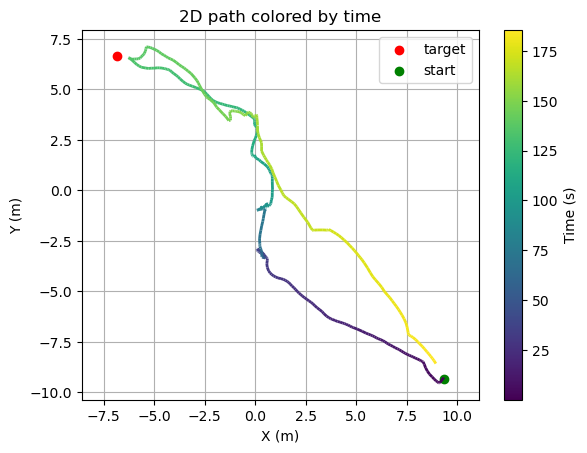

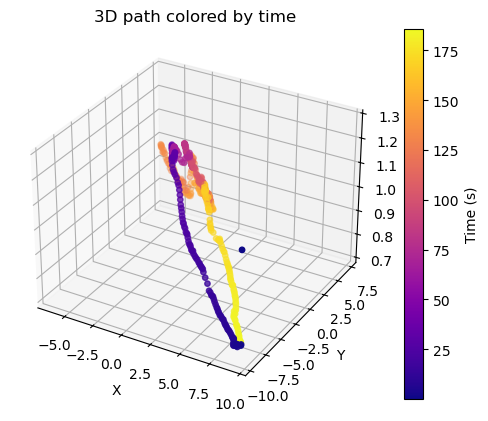

In [ ]:
# -------------------- Setup --------------------
start_obj = sim.getObject('/Start')
target_obj = sim.getObject('/Target')

start_xyz = sim.getObjectPosition(start_obj, -1)
target_xyz = sim.getObjectPosition(target_obj, -1)

start_xy = tuple(start_xyz[:2])
target_xy = tuple(target_xyz[:2])

log = []
sim_start_time = None
def log_current_position(log_list, start_time):
    pos = get_base_position()
    elapsed = time.time() - start_time
    log_list.append([round(pos[0], 3), round(pos[1], 3), round(pos[2], 3), round(elapsed, 2)])


print("\nStarting Env2...\n")
sim.startSimulation()
time.sleep(0.3)
sim_start_time = time.time()

success = goto_point_dynamic(
    target_xy,
    forward_speed=10.0,
    rotate_speed=10.0,
    dist_tolerance=1,
    log_fn=lambda: log_current_position(log, sim_start_time),
    obstacle_threshold=1
)

time.sleep(0.3)

print("⬅️ Navigating from Target → Start...")
success_back = goto_point_dynamic(
    start_xy,
    forward_speed=10.0,
    rotate_speed=10.0,
    dist_tolerance=1,
    log_fn=lambda: log_current_position(log, sim_start_time),
    obstacle_threshold=1
)

if success_back:
    print("Returned to Start!")
else:
    print("Could not return to Start!")


stop_wheels()
sim.stopSimulation()

if success:
    print("Mission complete: Reached target!")
else:
    print("Mission ended: Could not reach target.")

csv_path = "rover_path_env2.csv"
with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["x", "y", "z", "t"])
    writer.writerows(log)
print(f"Saved path log to {csv_path}")

if len(log) > 0:
    log_array = np.array(log)
    xs, ys, zs, ts = log_array[:,0], log_array[:,1], log_array[:,2], log_array[:,3]

    #2D 
    plt.figure()
    points = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    from matplotlib.collections import LineCollection
    lc = LineCollection(segments, cmap='viridis', linewidths=2)
    lc.set_array(ts)
    plt.gca().add_collection(lc)
    plt.scatter([target_xy[0]], [target_xy[1]], c='r', label='target')
    plt.scatter([start_xy[0]], [start_xy[1]], c='g', label='start')
    plt.xlabel('X (m)'); plt.ylabel('Y (m)'); plt.title('2D path colored by time')
    plt.colorbar(lc, label='Time (s)')
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.show()

    #3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    p = ax.scatter(xs, ys, zs, c=ts, cmap='plasma', s=15)
    fig.colorbar(p, ax=ax, label='Time (s)')
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title('3D path colored by time')
    plt.show()

-----------------------------------------------------------------------------------